<a href="https://colab.research.google.com/github/dk-wei/tensorflow-dojo/blob/main/tf_keras_classification_model_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dependency

In [ ]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.36 s (started: 2021-07-23 00:28:31 +00:00)


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 9.8 ms (started: 2021-07-23 00:28:34 +00:00)


In [ ]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0
time: 5.49 ms (started: 2021-07-23 00:28:34 +00:00)


# Load and preview Data

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

x_train_all = x_train_all / 255.0
x_test = x_test / 255.0

# 从training set拆分出val set
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)
time: 521 ms (started: 2021-07-23 00:28:34 +00:00)


In [ ]:
#x_train[0]

time: 923 µs (started: 2021-07-23 00:28:34 +00:00)


In [ ]:
print(np.max(x_train), np.min(x_train))

1.0 0.0
time: 65.8 ms (started: 2021-07-23 00:28:34 +00:00)


## Standardization 数据归一化/标准化

training, val和testing都需要归一化，但是都是以training的mean，std为基准

下面会用到`Batch Normalization`，就是layers每一层都会要normalization一次

In [ ]:
# x = (x-u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# x_train: [None, 28, 28] -> [None, 784] -> transform ->  [None, 28, 28]
# 每张图片先flatten到一维，归一化，再转回二维
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)   

# val和testing set直接用training set的均值和方差，所以不用fit_transform, 直接fit
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

time: 767 ms (started: 2021-07-23 00:28:34 +00:00)


In [ ]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105137
time: 32.2 ms (started: 2021-07-23 00:28:35 +00:00)


In [ ]:
# 只有一个通道的28*28黑白图片
x_train[0].shape

(28, 28)

time: 4.09 ms (started: 2021-07-23 00:28:35 +00:00)


In [ ]:
#x_train[0]

time: 651 µs (started: 2021-07-23 00:28:35 +00:00)


In [ ]:
#y_train

time: 659 µs (started: 2021-07-23 00:28:35 +00:00)


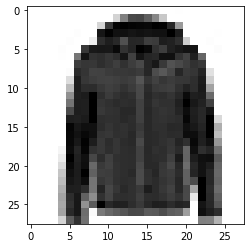

time: 129 ms (started: 2021-07-23 00:28:35 +00:00)


In [ ]:
def show_single_image(img_arr):

  # imshow可以直接打印图片
  plt.imshow(img_arr, cmap= 'binary', interpolation='nearest')
  plt.show()

show_single_image(x_train[0])

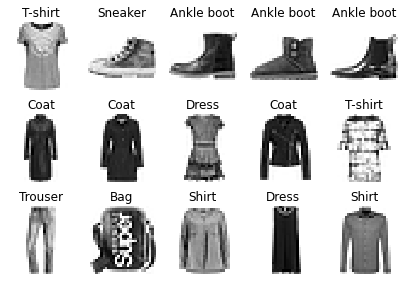

time: 448 ms (started: 2021-07-23 00:28:35 +00:00)


In [ ]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col + 1
            plt.subplot(n_rows, n_cols, index)
            plt.imshow(x_data[index], cmap='binary', interpolation='nearest')
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()
    
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=[28,28]))
# model.output_shape

time: 1.79 ms (started: 2021-07-23 00:28:36 +00:00)


# Training

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

time: 11.7 ms (started: 2021-07-23 00:28:36 +00:00)


In [ ]:
# tf.keras.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))

# 用for循环定义深度神经网络
for _ in range(20):

  '''
  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.BatchNormalization())    # 批归一化，防止梯度消失 gradient vanishing
  '''

  '''
  # 也可以把batch normalization放在activation function后面
  model.add(keras.layers.Dense(100)
  model.add(keras.layers.BatchNormalization()    # 批归一化，防止梯度消失 gradient vanishing
  model.add(keras.layers.Activation('relu)
  '''

  # 也可以只更改activation function为自带normalization功能的selu
  # 就不需要像上面一样每一层都带BatchNormalization了
  model.add(keras.layers.Dense(100, activation= 'selu'))

#model.add(keras.layers.AlphaDropout(rate = 0.5))
model.add(keras.layers.Dense(10, activation='softmax'))  # 最后一层用softmax区分度更高


# model = keras.models.Sequential([
     
#     keras.layers.Flatten(input_shape=[28,28]),    # 将28*28input压扁成一维向量1*728
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')  # 最后一层输出为1*10的向量 

# ])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3]
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[]
model.compile(loss='sparse_categorical_crossentropy',    # 之所以使用sparse_categorical_crossentropy是因为我们的y是[1, 2]这样的向量，而不是one hot，但是我们的模型输出是[[0.05, 0.95, 0], [0.1, 0.8, 0.1]]这样的one hot
              #optimizer='sgd',
              optimizer = 'adam',
              metrics=['accuracy', 
                       f1_m, 
                       precision_m, 
                       recall_m
                       ]
              )

time: 161 ms (started: 2021-07-23 00:28:36 +00:00)


In [ ]:
model.layers

time: 4.14 ms (started: 2021-07-23 00:28:36 +00:00)


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_88 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_89 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_90 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_91 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_92 (Dense)             (None, 100)              

In [ ]:
# 参数量w, b的由来
# [None, 784] * W + b -> [None, 300]
# W.shape = [784 * 300], b.shape = [300]

784*300+300

235500

time: 5.18 ms (started: 2021-07-23 00:28:36 +00:00)


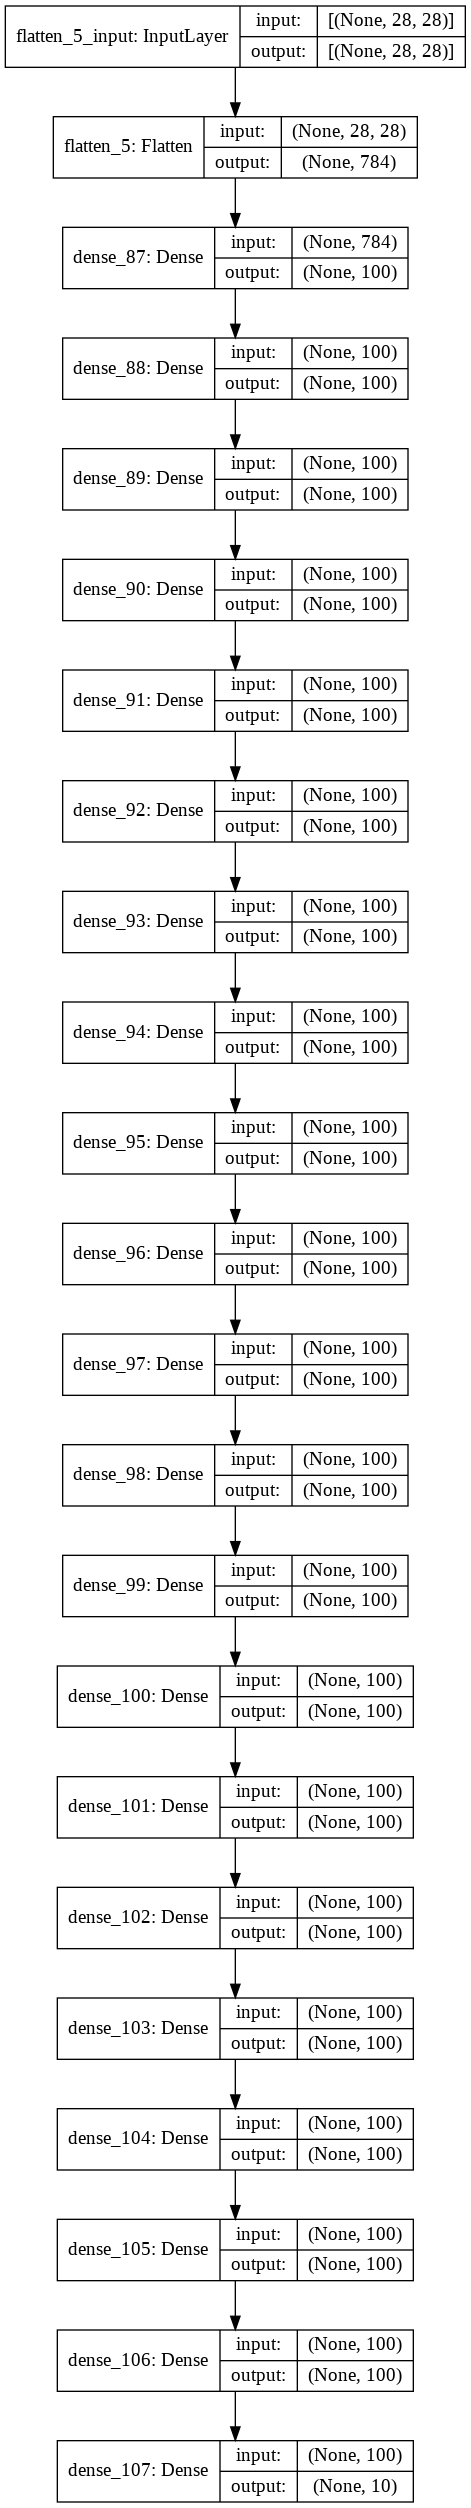

time: 447 ms (started: 2021-07-23 00:28:36 +00:00)


In [ ]:
keras.utils.plot_model(model, 
                       show_shapes=True, 
                       #rankdir="LR"
                       )

## Callbacks

Callbacks主要是训练模型途中的一些自动化操作，一般设置在fitting之前。最常用的一些callbacks有：
1. tensorboard  即时显示训练情况  
2. earlystopping 早停法
3. modelcheckpoint  保存(最优)模型

运行TensorBoard的方法：
在有`callbacks`文件的目录下运行


    tenforboard --logdir=callbacks

In [ ]:
# 结果一般都是保存着history这个变量里面
# 加入三种最常用的callbacks：tensorboard，earlystopping，modelcheckpoint

logdir = '/content/dnn-callbacks'
if not os.path.exists(logdir):
  os.mkdir(logdir)

output_model_file = os.path.join(logdir, 
                                 "fashion_mnist_model.h5")

callbacks = [
             keras.callbacks.TensorBoard(logdir),  # 将TensorBoard文件存在callbacks folder
             keras.callbacks.ModelCheckpoint(output_model_file,   # 将模型存在h5 file
                                             save_best_only = True),
             keras.callbacks.EarlyStopping(patience = 5,  # 设置早停
                                           min_delta = 1e-3 
             )
             
]

history = model.fit(
    x_train_scaled, 
    y_train, 
    epochs=10, 
    validation_data = (x_valid_scaled, y_valid),
    callbacks = callbacks,
    verbose = 1   # 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    )

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.7146 - accuracy: 0.7604 - f1_m: 1.5692 - precision_m: 1.6126 - recall_m: 1.5445 - val_loss: 0.6069 - val_accuracy: 0.8062 - val_f1_m: 1.5645 - val_precision_m: 1.5955 - val_recall_m: 1.5412
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5867 - accuracy: 0.8082 - f1_m: 1.4421 - precision_m: 1.4456 - recall_m: 1.4450 - val_loss: 0.5942 - val_accuracy: 0.8148 - val_f1_m: 1.3511 - val_precision_m: 1.3509 - val_recall_m: 1.3547
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5251 - accuracy: 0.8266 - f1_m: 1.3950 - precision_m: 1.3937 - recall_m: 1.4023 - val_loss: 0.5333 - val_accuracy: 0.8142 - val_f1_m: 1.5411 - val_precision_m: 1.5712 - val_recall_m: 1.5176
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4976 - accuracy: 0.8358 - f1_m: 1.3840 - precision_m: 1.3818 - recall_m: 1.3919 - val_loss: 0.6024 - val_accuracy: 0.

In [ ]:
ls

callbacks/  dnn-callbacks/  model.png  sample_data/
time: 148 ms (started: 2021-07-23 00:29:47 +00:00)


In [ ]:
# 启动tensorboard

#%tensorboard --logdir=callbacks

time: 1.3 ms (started: 2021-07-23 00:29:47 +00:00)


In [ ]:
type(history) # history其实是一个callback

tensorflow.python.keras.callbacks.History

time: 4 ms (started: 2021-07-23 00:29:47 +00:00)


In [ ]:
history.epoch

history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])

time: 3.59 ms (started: 2021-07-23 00:29:47 +00:00)


In [ ]:
history.history

{'accuracy': [0.760381817817688,
  0.8082363605499268,
  0.8265818357467651,
  0.8357818126678467,
  0.8061272501945496,
  0.8091636300086975,
  0.8324727416038513,
  0.7408909201622009],
 'f1_m': [1.5692473649978638,
  1.4421066045761108,
  1.394980788230896,
  1.3839789628982544,
  1.4849307537078857,
  1.5132699012756348,
  1.4238612651824951,
  1.818153738975525],
 'loss': [0.7146227955818176,
  0.5866561532020569,
  0.5251113772392273,
  0.4975692331790924,
  0.5695429444313049,
  0.5687930583953857,
  0.5010467767715454,
  0.7077155113220215],
 'precision_m': [1.6126161813735962,
  1.4456377029418945,
  1.3937046527862549,
  1.381751298904419,
  1.518338680267334,
  1.5323314666748047,
  1.4272228479385376,
  1.9928120374679565],
 'recall_m': [1.5445433855056763,
  1.4450373649597168,
  1.4022977352142334,
  1.3918896913528442,
  1.463160514831543,
  1.5033074617385864,
  1.4268252849578857,
  1.6925125122070312],
 'val_accuracy': [0.8062000274658203,
  0.8148000240325928,
  0.81

time: 5.73 ms (started: 2021-07-23 00:29:47 +00:00)


# Plot Validation 

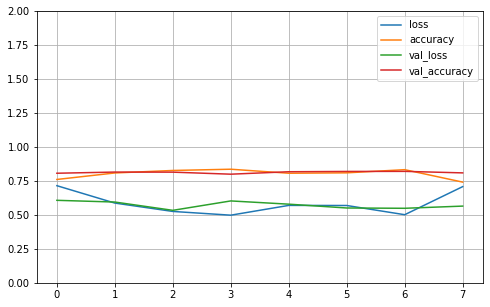

time: 234 ms (started: 2021-07-23 00:29:47 +00:00)


In [ ]:
def plot_learning_curves(history):

    # 选择需要plot的metrics，否则变量太多了
    plot_metrics = {k:v for k,v in history.history.items() if k in ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

    pd.DataFrame(plot_metrics).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 2)
    plt.show()
    
plot_learning_curves(history)

In [ ]:
 model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6016 - accuracy: 0.7883 - f1_m: 1.6451 - precision_m: 1.6900 - recall_m: 1.6091


[0.6015520095825195,
 0.7882999777793884,
 1.6451228857040405,
 1.6899892091751099,
 1.6090642213821411]

time: 1.31 s (started: 2021-07-23 00:29:47 +00:00)
